In [1]:
import os, glob
sys.path.append('../')

import SimpleITK as sitk
import numpy as np

from radiomics import featureextractor

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted'

patients = os.listdir(src)
if '.DS_Store' in patients:
    patients.remove('.DS_Store')
print(f"Number of patients: {len(patients)}")

Number of patients: 48


In [3]:
params  = '../extras/Params.yaml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)

features = {}

for patient in patients:

    folders = glob.glob(src + '/' + patient + '/*_3D')
    
    res = [y for y in folders if '_resized' in y ]
    pred = [x.replace('_resized', '_predicted') for x in res ]
    
    for (x, y) in zip(res, pred):
        
        image = sitk.ReadImage(x + "/grayscale.nrrd")
        mask = sitk.ReadImage(y + "/segmented.nrrd")

        folder_name = os.path.split(x)[1]
        fold_prefix = folder_name.split('_')[0]

        
        
        features[patient, fold_prefix] = extractor.execute(image, mask)

In [4]:
import pickle

with open('../data/features/'  + 'features.pickle', 'wb') as file:
     pickle.dump(features, file)

In [5]:
dict_list = list(features)

print('NUMEBR OF CASE_ID: ', len(dict_list))
print(dict_list)

feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features[dict_list[0]] )))
print('NUMEBR OF FEATURES: ', len(feature_names))

NUMEBR OF CASE_ID:  50
[('BO77', 'T2'), ('BO48', 'T2'), ('BO47', 'T2'), ('BO78', 'T2'), ('BO40', 'T2AX'), ('BO76', 'T2'), ('BO82', 'T2'), ('BO49', 'T2'), ('BO85', 'T2'), ('BO71', 'T2'), ('BO2', 'T2AX'), ('BO54', 'T2'), ('BO31', 't2DEF'), ('BO36', 'T2AX'), ('BO38', 'T2AXAlta'), ('BO38', 'T2AXbassa'), ('BO64', 'T2'), ('BO90', 'T25mm'), ('BO63', 'T2'), ('BO52', 'T2'), ('BO39', 'T2AX'), ('BO37', 'T2AX'), ('BO74', 'T2'), ('BO45', 'T2'), ('BO42', 'T2AX'), ('BO29', 'T2AX'), ('BO16', 'T2AX'), ('BO11', 'T2AX'), ('BO18', 'T2AX'), ('BO43', 'T2AX'), ('BO44', 'T2AX'), ('BO86', 'T2'), ('BO72', 'T2'), ('BO75', 'T2'), ('BO26', 'T2AX'), ('BO28', 'T2AX'), ('BO17', 'T2AX'), ('BO9', 'T2AX'), ('BO1', 'T2AX'), ('BO35', 'T2AX'), ('BO32', 'T2AX'), ('BO68', 'T2'), ('BO50', 'T2'), ('BO66', 'T2'), ('BO61', 'T2'), ('BO33', 'T2AX'), ('BO60', 'T2'), ('BO51', 'T2'), ('BO56', 'T2'), ('BO56', 'T25mm')]
NUMEBR OF FEATURES:  100


In [6]:
samples = np.zeros((len(dict_list), len(feature_names)))

for k, case_id in enumerate(dict_list):
    a = np.array([])
    for feature_name in feature_names:
        a = np.append(a, features[case_id][feature_name])
    samples[k, ...] = a

#for possible NaNs
samples = np.nan_to_num(samples)

samples.shape

(50, 100)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [8]:
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names)

d.describe()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
count,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,32.480000,75.860000,3.920636e+07,1.394797,22.580000,5.225956,129.580000,52.094724,13.812320,50.240000,...,52.833715,78.522458,82.302577,93.721165,11486.180833,37.295232,0.200442,12291.054028,1.296442,11708.080000
std,12.878142,36.923534,7.205368e+07,0.472358,20.089687,2.653650,41.448315,22.488541,9.699654,25.131134,...,13.720183,36.575942,41.627183,42.774006,11460.987922,10.849375,0.043557,9425.284017,0.385650,11511.206784
min,7.000000,19.000000,2.812145e+06,0.161743,4.000000,1.396573,45.000000,12.630192,3.670944,12.000000,...,30.413813,33.955854,37.121422,44.429720,1317.000000,19.664637,0.129709,2467.108701,0.696675,1427.000000
25%,24.250000,54.000000,9.723657e+06,1.062803,13.000000,3.179057,100.000000,39.761957,8.463442,38.000000,...,44.714780,52.723315,50.741904,58.650266,4663.385417,30.246692,0.168165,6202.816822,0.959803,4896.250000
50%,32.000000,65.500000,1.960480e+07,1.350518,18.500000,4.776679,128.000000,48.609043,11.411372,45.000000,...,50.427851,64.818992,67.722291,76.983660,7609.041667,35.475613,0.195175,9159.064886,1.271760,7779.500000
75%,40.250000,90.750000,3.941342e+07,1.658869,21.750000,6.679542,159.000000,60.781980,14.506253,55.750000,...,56.753558,101.345775,107.561907,123.079707,13389.520833,41.066068,0.215684,15071.830223,1.504141,13507.500000
max,77.000000,190.000000,4.941595e+08,2.415244,118.000000,14.146181,216.000000,126.741112,55.688438,163.000000,...,108.558740,173.833253,186.978608,188.403822,56586.291667,82.536989,0.336484,50439.899002,2.170261,56953.000000


<AxesSubplot:>

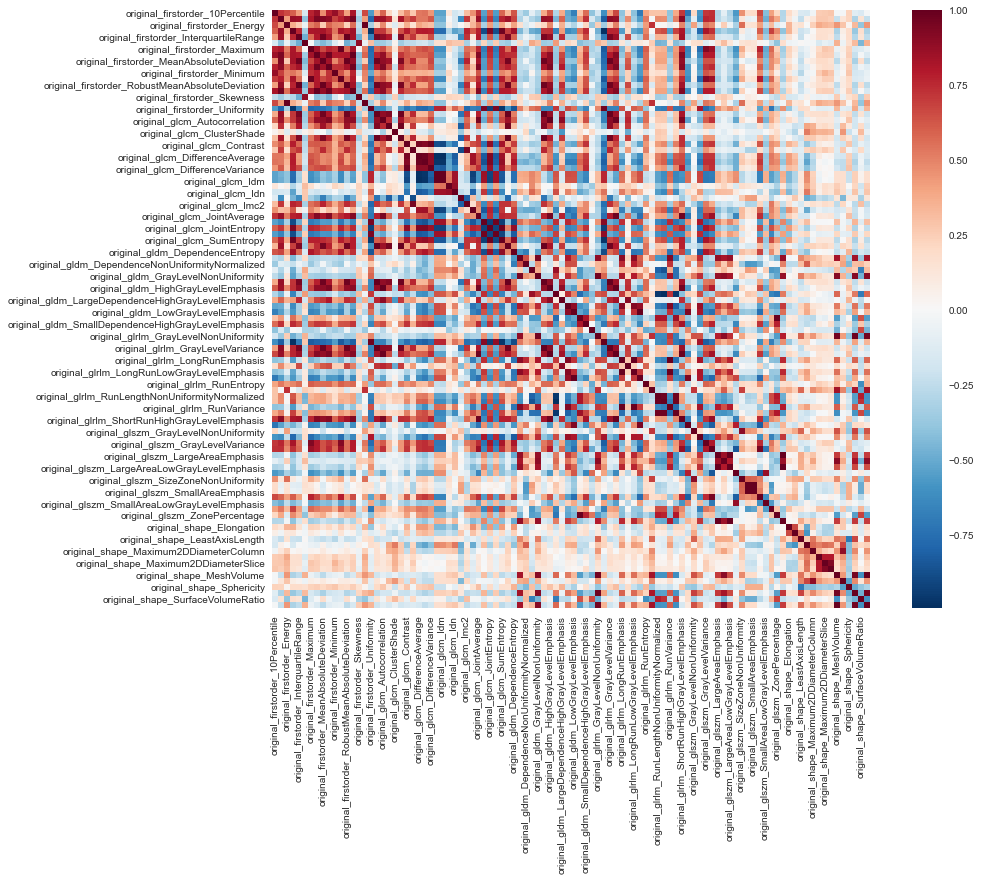

In [41]:
corr = d.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 11))

# Draw the heatmap using seaborn
sns.heatmap(corr, square=True, cmap="RdBu_r")

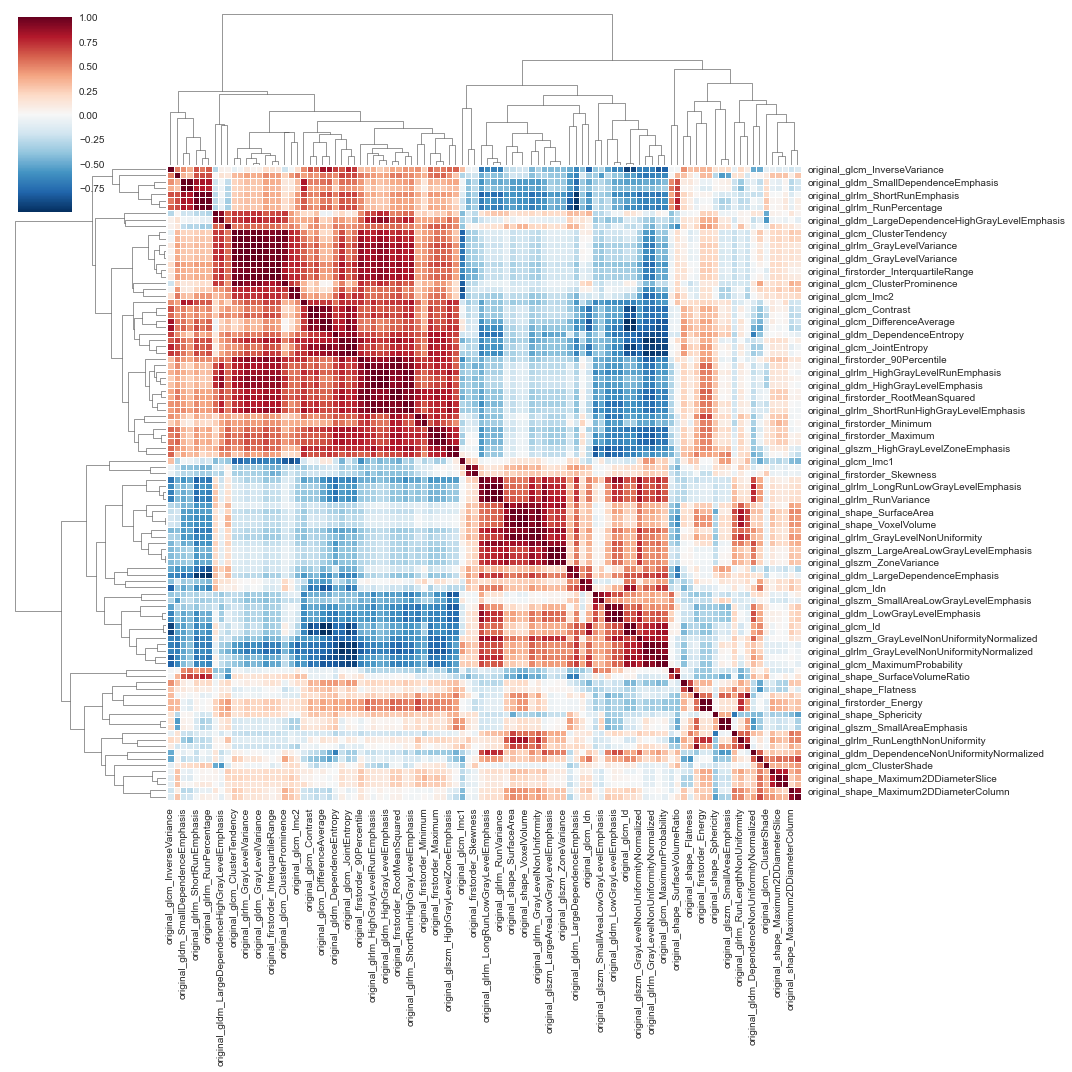

In [42]:
pp = sns.clustermap(d.corr(), linewidths=.6, figsize=(15,15), cmap='RdBu_r')
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()